In [1]:
import os
import pandas as pd
import pickle

In [2]:
def merge_pickled_dictionaries(main_folder_path, protein):
    i = 0
    merged_dict = {}
    for root, dirs, files in os.walk(main_folder_path):
        # Check if the current directory has a subdirectory with the protein name
        if protein in dirs:
            # Construct the path to the protein-specific subsubfolder
            protein_folder_path = os.path.join(root, protein)
            # Look for the 'scores_dict.pkl' file specifically in the protein folder
            for root_protein, dirs_protein, files_protein in os.walk(protein_folder_path):
                if 'scores_dict.pkl' in files_protein:
                    try:
                        file_path = os.path.join(root_protein, 'scores_dict.pkl')
                        with open(file_path, 'rb') as f:
                            data = pickle.load(f)
                        if isinstance(data, dict):
                            merged_dict.update(data)
                        else:
                            pass
                    except Exception as e:
                        print(f"Error: {e}")
                        i += 1
                        
    print(f"Number of errors: {i}")
    return merged_dict

In [5]:
%%time

main_folder_path = './input'
protein          = 'adcy5'
merged_dict      = merge_pickled_dictionaries(main_folder_path, protein)

Number of errors: 0
CPU times: user 4.46 s, sys: 2.98 s, total: 7.45 s
Wall time: 1min 22s


In [7]:
len(merged_dict)

2321650

In [5]:
#with open('./input/chembl_split_dir_1/scores_dict.pkl', 'rb') as file:
#    f = pickle.load(file)

In [6]:
#len(f)

In [20]:
%%time

df = pd.DataFrame.from_dict(merged_dict)

CPU times: user 924 ms, sys: 8.9 ms, total: 933 ms
Wall time: 932 ms


In [21]:
df = df.T

In [22]:
df.columns = ['score1']

In [23]:
df

,score1
CHEMBL1402028,-4.534
CHEMBL1402029,-6.432
CHEMBL5073571,Error atoms not valid for PDBQT
CHEMBL1402030,-7.23
CHEMBL1403343,-7.756
...,...
CHEMBL1391592,-6.516
CHEMBL1393606,-7.813
CHEMBL1393607,-6.86
CHEMBL5021399,-6.088


22 percent error rate

In [16]:
filtered_df = df[df.score1.apply(lambda x: isinstance(x, float))]

In [17]:
filtered_df

,score1
CHEMBL2179112,-9.785
CHEMBL2179113,-9.441
CHEMBL2179114,-8.582
CHEMBL2179367,-6.746
CHEMBL2179368,-6.672
...,...
CHEMBL4173260,-7.206
CHEMBL4173261,-10.167
CHEMBL4173262,-8.225
CHEMBL4173264,-8.014


In [182]:
filtered_df.score1 = pd.to_numeric(filtered_df.score1)

/tmp/ipykernel_42915/4112380832.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.score1 = pd.to_numeric(filtered_df.score1)


In [184]:
filtered_df.min()

score1   -22.833
dtype: float64

In [183]:
filtered_df = filtered_df.drop(['score2'], axis=1)

In [185]:
filtered_df

,score1
CHEMBL2179112,-6.468
CHEMBL2179113,-6.559
CHEMBL2179114,-6.911
CHEMBL2179367,-5.266
CHEMBL2179368,-5.190
...,...
CHEMBL4173260,-5.733
CHEMBL4173261,-7.381
CHEMBL4173262,-6.838
CHEMBL4173264,-6.349


<AxesSubplot:ylabel='Frequency'>

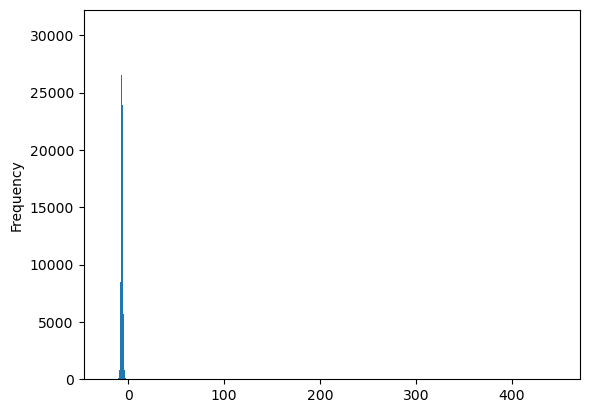

In [161]:
filtered_df.score1.plot.hist(bins=10000)

In [187]:
def categorize_score(score):
    if score <= -15.0:
        return 'Very strong'
    elif score <= -9.0:
        return 'Strong'
    elif score <= -7.0:
        return 'Medium'
    else:
        return 'Weak'

filtered_df['affinity1'] = filtered_df['score1'].apply(categorize_score)

In [188]:
filtered_df.affinity1.value_counts()

affinity1
Weak           1114451
Medium          409278
Strong            9480
Very strong         22
Name: count, dtype: int64

In [189]:
filtered_df.score1.idxmin()

'CHEMBL3431053'

In [190]:
filtered_df.score1.min()

-22.833

# Dock again

In [20]:
import pandas as pd
import py3Dmol

from src.preparation          import prepare_protein, prepare_ligand, convert_pdb_to_pdbqt
from src.p2rank_pocket_finder import P2RankPocketFinder
from rdkit                    import Chem
from deepchem.dock.pose_generation import VinaPoseGenerator

In [2]:
chembl  = pd.read_table('data/chembl_33_chemreps.txt', sep='\t')

In [3]:
#id = filtered_df.score1.idxmin()
id = 'CHEMBL3431053'

In [4]:
ligand = chembl[chembl.chembl_id == id].iloc[0].canonical_smiles

In [51]:
ligand

'Nc1nc(-c2ccccn2)nc(-n2nc(-c3ccccc3)cc2N)n1.O=C(O)C(F)(F)F.O=C(O)C(F)(F)F.O=C(O)C(F)(F)F.O=C(O)C(F)(F)F.O=C(O)C(F)(F)F.O=C(O)C(F)(F)F.O=C(O)C(F)(F)F.O=C(O)C(F)(F)F'

In [5]:
protein      = 'proteins/slc6a19.pdb'
protein_name = 'slc6a19'

In [6]:
directory_path  = './analysis'
ligand_sdf_path = directory_path + '/' + id + '.sdf'

In [7]:
protein_pdb_path = directory_path + '/' + protein_name + '.pdb'
print(protein_pdb_path)
p = prepare_protein(protein, protein_pdb_path)
Chem.rdmolfiles.MolToPDBFile(p, protein_pdb_path)

./analysis/slc6a19.pdb


In [8]:
m = prepare_ligand(ligand)
ligand_pdb_path = directory_path + '/' + id + '.pdb'
Chem.rdmolfiles.MolToPDBFile(m, ligand_pdb_path)
convert_pdb_to_pdbqt(ligand_pdb_path, ligand_sdf_path, is_ligand=True)

2024-02-23 11:46:34,022 - INFO - Converting ligand using OpenBabel.

*** Open Babel Error  in openLib
  /oak/stanford/groups/mrivas/projects/multiomics/tlmenest/conda/envs/docking/lib/openbabel/3.1.0/png2format.so did not load properly.
 Error: libXrender.so.1: cannot open shared object file: No such file or directory
1 molecule converted


In [9]:
pocket_finder = P2RankPocketFinder(
    'p2rank_2.4.1/test_output/predict_slc6a19/slc6a19.pdb_predictions.csv',
    ligand_mol = m, threshold = 0.6)

In [10]:
num_modes      = 1
exhaustiveness = 1
cpu            = 10

vpg = VinaPoseGenerator(pocket_finder = pocket_finder)

In [11]:
complexes, scores = vpg.generate_poses(
    molecular_complex=(protein_pdb_path, ligand_sdf_path), 
    out_dir = directory_path, generate_scores = True, 
    num_modes = num_modes, cpu = cpu, seed = 123, 
    exhaustiveness = exhaustiveness)

[11:46:39] Explicit valence for atom # 3 C, 14, is greater than permitted


Computing Vina grid ... done.
Performing docking (random seed: -501079953) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


In [12]:
final_scores = [scores[i:i + num_modes] for i in range(0, len(scores), num_modes)]
smallest_scores_per_list = [min(sublist) for sublist in final_scores]

In [13]:
final_scores

[[-19.731]]

In [14]:
complexes

[(<rdkit.Chem.rdchem.Mol at 0x7f6121510b20>,
  <rdkit.Chem.rdchem.Mol at 0x7f61161968c0>)]

In [49]:
def visualize_molecule(molecule1, molecule2, width=800, height=600):
    """
    Visualize an RDKit molecule using Py3Dmol.
    
    :param molecule1: RDKit molecule object for the protein.
    :param molecule2: RDKit molecule object for the ligand.
    :param width: Width of the visualization window.
    :param height: Height of the visualization window.
    """

    # Check if 3D coordinates exist or generate them
    if not molecule1.GetNumConformers():
        AllChem.EmbedMolecule(molecule1)
    if not molecule2.GetNumConformers():
        AllChem.EmbedMolecule(molecule2)

    mb1 = Chem.MolToMolBlock(molecule1)
    mb2 = Chem.MolToMolBlock(molecule2)

    viewer = py3Dmol.view(width=width, height=height)
    viewer.addModel(mb1, 'mol')  # Add the first molecule
    viewer.addModel(mb2, 'mol')  # Add the second molecule

    # Apply a cartoon representation to the first molecule (protein)
    #viewer.setStyle({'model': 0}, {'cartoon': {}})  # Apply cartoon style to first molecule
    
    # Apply stick representation to the second molecule (ligand)
    viewer.setStyle({'model': 1}, {'stick': {'radius': 0.3, 'colorscheme': 'greenCarbon'}})

    # Adjust the zoom to show the ligand clearly
    viewer.zoomTo({'model': 1})  # Zoom to the ligand
    viewer.zoom(0.8)  # Zoom out slightly to provide a better view

    return viewer.show()

In [50]:
visualize_molecule(complexes[0][0], complexes[0][1], 800, 600)

[12:15:20] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol